In [163]:
# Import des packages 
import pandas as pd
import numpy as np
import sklearn
import pickle

import os 
import pathlib


import plotly.express as px
import matplotlib as plt

# Insérez votre code ici
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

path_to_data = r"C:\Users\Inrae\Documents\Projet_Data_Science"
data_folder_path = os.path.join(path_to_data,"COVID-19_Radiography_Dataset")
output_path = os.path.join(path_to_data,"processed")
size=(128, 128)



In [164]:

# Charger les données d'images
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    output_path,
    image_size = size,  # Redimensionner les imags
    batch_size = 32,
    label_mode = None,
    color_mode = "grayscale",
    shuffle = False
)

# Récupérer les noms des fichiers dans le dataset
#file_paths = [os.path.join(output_path, fname) for fname in dataset.file_paths]

# Charger les metadonnees
glob_add_info_df = pd.DataFrame()

for classes in ['COVID','Lung_Opacity','Normal','Viral_Pneumonia']:
    # Charger le fichier CSV
    filename=classes+".metadata.xlsx"
    file_path = os.path.join(output_path,filename)
    additional_info_df = pd.read_excel(file_path)


    # On cree une colonne correspondant aux labels
    additional_info_df['LABELS'] = classes
   
    # Dans les noms de fichiers, On remplace les Viral Pneumonia par Viral_Pneumonia et NORMAL par Normal
    #additional_info_df['FILE NAME'] = additional_info_df['FILE NAME'].str.replace('Viral Pneumonia', 'Viral_Pneumonia')
    additional_info_df['FILE NAME'] = additional_info_df['FILE NAME'].str.replace('NORMAL', 'Normal')

    class_path = os.path.join(output_path,classes)
    additional_info_df['FILE NAME'] = class_path + "\\" + additional_info_df['FILE NAME'] + ".png_masked.png"
    
    # On recode les URL
    additional_info_df.replace({
    "https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data" : "rnsa",
    "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia" : "pneumonia-chestxray",                     
    "https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711"  : "bimcv",
    "https://github.com/armiro/COVID-CXNet" : "CXNet",
    "https://eurorad.org" : "eurorad",                                                            
    "https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png"  : "ml-workgroup",
    "https://github.com/ieee8023/covid-chestxray-dataset" : "covid-chestxray",
    "https://sirm.org/category/senza-categoria/covid-19/" : "senza",
    },
    inplace = True
    )

    # On supprime l info size et formal 
    additional_info_df = additional_info_df.drop(["FORMAT", "SIZE"], axis = 1)
    
    # Ajouter les données de cette classe au DataFrame global
    glob_add_info_df = pd.concat([glob_add_info_df,additional_info_df], ignore_index=True)


glob_add_info_df.head()


Found 21165 files.


FILE NAME    URL LABELS
0  C:\Users\Inrae\Documents\Projet_Data_Science\p...  senza  COVID
1  C:\Users\Inrae\Documents\Projet_Data_Science\p...  senza  COVID
2  C:\Users\Inrae\Documents\Projet_Data_Science\p...  senza  COVID
3  C:\Users\Inrae\Documents\Projet_Data_Science\p...  senza  COVID
4  C:\Users\Inrae\Documents\Projet_Data_Science\p...  senza  COVID

In [165]:
# Extraire les images et les aplatir en vecteurs
images = []
for image_batch in dataset:
    image_batch = image_batch.numpy().reshape(image_batch.shape[0], -1)
    images.append(image_batch)

# Convertir les images en un tableau numpy
images = np.vstack(images)

In [166]:
filenames =  dataset.file_paths

# On verifie que tout est OK dans les noms de fichiers
for filename in filenames:
    if filename not in glob_add_info_df['FILE NAME'].values:
        print(f"Missing: {filename}")

# On reeordonne selon l ordre des fichiers
glob_add_info_df_order = glob_add_info_df.set_index('FILE NAME').loc[filenames].reset_index()


## On fait les comptages par categories

In [167]:
# On affiche les images par catégories ou par source avec plotly express
px.histogram(glob_add_info_df_order, x="LABELS", color="URL")


## On fait les statistiques exploratoires par categories (label ou source)

In [168]:
import numpy as np
import pandas as pd
import plotly.express as px

# Créer un DataFrame avec les images et informations supplémentaires
df = pd.DataFrame({
    'label': glob_add_info_df_order.LABELS,
    'source': glob_add_info_df_order.URL,
    'image': list(images)  # Chaque image est un vecteur de pixels
})

# Ajouter une nouvelle colonne 'label_source' qui combine 'label' et 'source'
df["label_source"] = df["label"] + "_" + df["source"]

# Calculer la moyenne et l'écart-type des pixels pour chaque image
df['mean_pixel'] = df['image'].apply(lambda x: np.mean(x))
df['std_pixel'] = df['image'].apply(lambda x: np.std(x))

def plot_mean_std(df, cat="label"):
# Créer un graphique avec Plotly
    fig = px.scatter(
        df, 
        x='mean_pixel',  # Moyenne des pixels
        y='std_pixel',   # Ecart-type des pixels
        color=cat,  # Couleur selon le label_source
        title="Moyenne et Ecart-Type des Pixels par " +  cat,
        labels={'mean_pixel': 'Moyenne des Pixels', 'std_pixel': 'Ecart-Type des Pixels'},
        #template="plotly_dark"
        )  # Utilisation d'un fond sombre
    fig.show()
    

def boxplot(df, cat="label"):
    # Créer un barplot avec Plotly
    fig = px.box(
        df, 
        x=cat,                # Les catégories (sur l'axe des abscisses)
        y='mean_pixel',       # La moyenne des pixels (sur l'axe des ordonnées)
        #error_y='std_pixel',  # L'écart-type comme barre d'erreur
        color=cat,            # Couleur selon la catégorie (cat)
        title=f"Boxplot des Moyennes des Pixels par {cat}",
        #template="plotly_dark"
    )
    
    # Afficher le graphique
    fig.show()



In [169]:
display(df.head())
boxplot(df, cat="source")

plot_mean_std(df, cat="label")


label           source                                              image  \
0  COVID            senza  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  COVID            senza  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  COVID            senza  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  COVID  covid-chestxray  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  COVID  covid-chestxray  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

            label_source  mean_pixel  std_pixel  
0            COVID_senza   29.636143  54.350311  
1            COVID_senza   31.992931  53.994999  
2            COVID_senza   27.699493  53.282795  
3  COVID_covid-chestxray   33.210274  61.706135  
4  COVID_covid-chestxray   18.745560  45.347660

In [170]:
# On exporte le dataset sans le fichier image

df_mean_std = df.drop(columns=['image'])
path_df = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","df_mean_std.pkl")
display(df_mean_std.head())

print(path_df)
df_mean_std.to_pickle(path_df)


label           source           label_source  mean_pixel  std_pixel
0  COVID            senza            COVID_senza   29.636143  54.350311
1  COVID            senza            COVID_senza   31.992931  53.994999
2  COVID            senza            COVID_senza   27.699493  53.282795
3  COVID  covid-chestxray  COVID_covid-chestxray   33.210274  61.706135
4  COVID  covid-chestxray  COVID_covid-chestxray   18.745560  45.347660

C:\Users\Inrae\Documents\Projet_Data_Science\radio_pulmo\src\streamlit\resources\df_mean_std.pkl


# On fait les images moyennes par label_source

In [171]:
# Calculer la moyenne de l'image pour chaque catégorie/source
average_images = df.groupby("label_source")['image'].apply(lambda x: np.mean(np.vstack(x), axis=0)).reset_index()

# Reshape l'image moyenne (si nécessaire pour l'affichage)
average_images['image'] = average_images['image'].apply(lambda x: x.reshape(size[0],size[1],1))

# Affichage du DataFrame avec les images moyennes
average_images.head()


label_source                                              image
0            COVID_CXNet  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
1            COVID_bimcv  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
2  COVID_covid-chestxray  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
3          COVID_eurorad  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
4     COVID_ml-workgroup  [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...

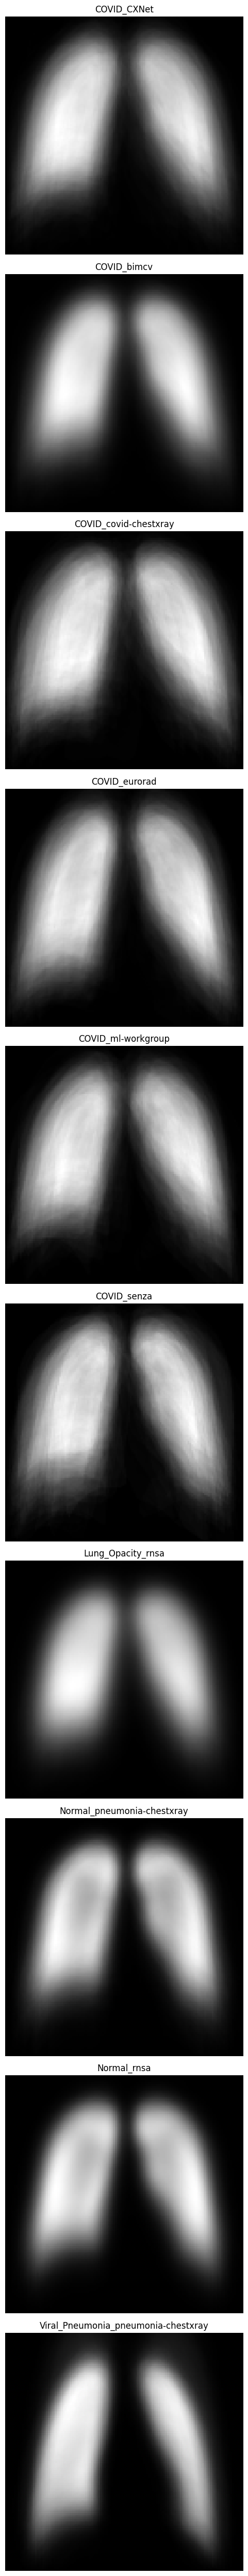

In [172]:

# Affichage des images moyennes par catégorie et source
fig, axes = plt.subplots(len(average_images), 1, figsize=(5, 50), )

for i, row in enumerate(average_images.itertuples()):
    ax = axes[i]
    ax.imshow(row.image, cmap="gray")
    ax.set_title(row.label_source)
    ax.axis('off')  
    
plt.tight_layout()
plt.show()

In [173]:

# Remise en forme des images
average_images['image'] = average_images['image'].apply(lambda x: np.squeeze(x))  # Enlève les dimensions inutiles


# Verifier le fichier average_image

display(average_images)

# Vérification de la forme des images
print(average_images['image'].iloc[0].shape)  # Affiche la forme d'une image pour vérification

path_avg_image = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","avg_image_label_source.pkl")

# Exporter le DataFrame avec les images nettoyées dans un fichier pickle
with open(path_avg_image, 'wb') as f:
    pickle.dump(average_images, f)

label_source  \
0                          COVID_CXNet   
1                          COVID_bimcv   
2                COVID_covid-chestxray   
3                        COVID_eurorad   
4                   COVID_ml-workgroup   
5                          COVID_senza   
6                    Lung_Opacity_rnsa   
7           Normal_pneumonia-chestxray   
8                          Normal_rnsa   
9  Viral_Pneumonia_pneumonia-chestxray   

                                               image  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
5  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
6  [[0.0, 0.0, 0.0, 0.012041022, 0.013953863, 0.0...  
7  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
8  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
9  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

(128, 128)


## On fait une ACP 

In [174]:
# Normaliser les images (centrer et réduire)
scaler = StandardScaler()
images_flattened = np.array([image.flatten() for image in df['image']])
images_scaled = scaler.fit_transform(images_flattened) 

# Appliquer l'ACP sur les images normalisées
pca = PCA(n_components=0.95)
images_pca = pca.fit_transform(images_scaled)

print("il faut ",  len(pca.explained_variance_ratio_), "pour expliquer 95% de la variance initiale")



il faut  843 pour expliquer 95% de la variance initiale


## Variance expliquée par les composantes

In [176]:
# On refait avec 10 composantes uniquement

# Appliquer l'ACP sur les images normalisées
pca = PCA(n_components=20)
images_pca = pca.fit_transform(images_scaled)

# Tracer le graph d ecolution de la variance

explained_variance = pca.explained_variance_ratio_

def plot_var(i):
    # Vérifier que l'indice i est dans les limites de explained_variance
    if i > len(explained_variance):
        print(f"Erreur: i doit être inférieur ou égal à {len(explained_variance)}")
        return
    
    # Créer un DataFrame pour utiliser avec Plotly
    x_values = range(1, i+1)
    y_values = explained_variance[:i]
    cumulative_values = explained_variance.cumsum()[:i]
    
    # Créer le graphique avec Plotly Express
    fig = px.bar(
        x=x_values,
        y=cumulative_values,
        title="Évolution de la variance expliquée par les composantes principales",
        labels={'x': 'Numéro de la composante principale', 'y': 'Variance cumulée'},
        text=y_values.round(3)
    )

    fig.update_traces(texttemplate='%{text:.3f}') 
    # Afficher le graphique
    fig.show()

# Exemple d'utilisation : plotter les 10 premières composantes
plot_var(5)


## Représentation des catégories sur les composantes

In [179]:

def plot3d_pca(num_components = [0, 1, 2], supp = "label"):
    total_var = pca.explained_variance_ratio_[num_components].sum() * 100
    supp = df[supp]
    cats = supp.unique()

    if len(num_components) == 3:
        
        fig = px.scatter_3d(

            images_pca, x = num_components[0], y =  num_components[1], z =  num_components[2], color = supp,
            title=f'Total Explained Variance: {total_var:.2f}%',
            
        )
        fig.update_layout(scene=dict(xaxis=dict(backgroundcolor='darkgray', gridcolor='gray', tickcolor='white', title = "PC_" +  str(num_components[0])),
                yaxis=dict(backgroundcolor='darkgray', gridcolor='gray', tickcolor='white',  title = "PC_" +  str(num_components[1])),
                zaxis=dict(backgroundcolor='darkgray', gridcolor='gray', tickcolor='white', title = "PC_" +  str(num_components[2] ))))
        fig.update_traces(marker=dict(size=2))
        fig.show()

    if len(num_components) == 2:
        fig = px.scatter(

            images_pca, x = num_components[0], y =  num_components[1], color = supp,
            title=f'Total Explained Variance: {total_var:.2f}%',
           )
        fig.update_layout(scene=dict(xaxis=dict(backgroundcolor='slategray', gridcolor='lightgray', tickcolor='white', title = "PC_" +  str(num_components[0])),
                yaxis=dict(backgroundcolor='slategray', gridcolor='lightgray', tickcolor='white',  title = "PC_" +  str(num_components[1])))) 
        
        fig.update_traces(marker=dict(size=2))
        fig.show()



### On affiche l image moyenne par label et par source

In [180]:

plot3d_pca([0,1], "label")

plot3d_pca([2,3], "label")

In [181]:

plot3d_pca([0,1], "source")

plot3d_pca([2,3], "source")

## Afficher les images des composantes

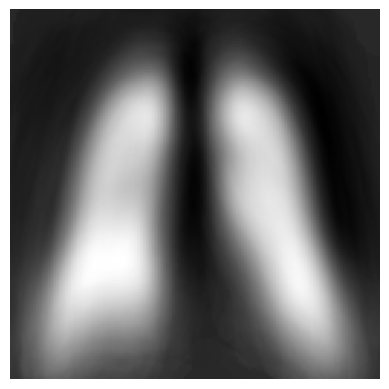

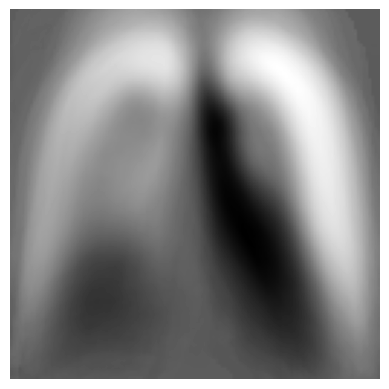

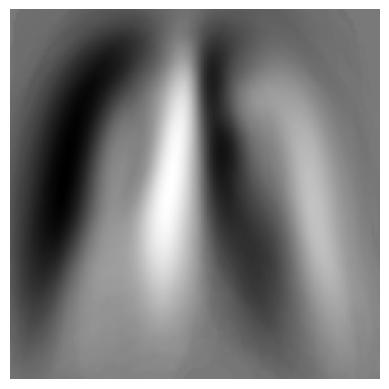

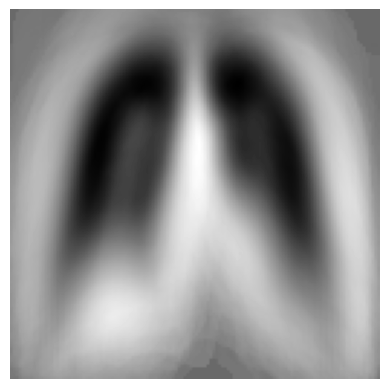

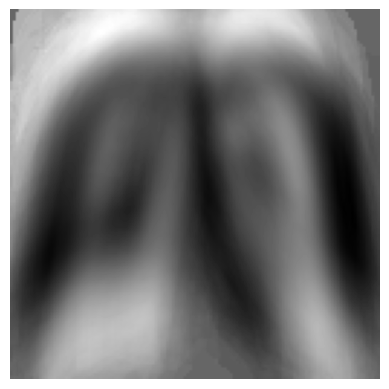

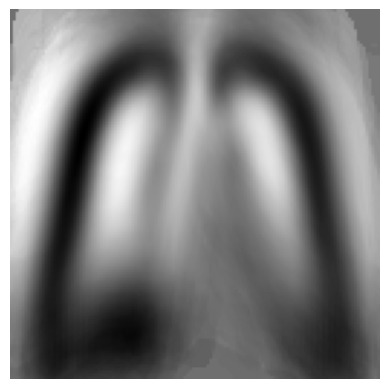

In [183]:
def display_mean_image(i=0):
    plt.figure()
    plt.imshow(pca.components_[i].reshape(size), cmap = 'gray')
    plt.axis('off')  # Enlève les axes
    plt.show()


for i in range(6):
    display_mean_image(i)


In [184]:
# On exporte en dataframe les images et leur composantes 

# On transforme en dataframe
pca_df = pd.DataFrame(images_pca)

# On ajoute les infos supplémentaires
pca_df['label'] = df['label']
pca_df['source'] = df['source']
pca_df['label_source'] = df['label_source']

# On cree l adresse du fichier de sortie

path_pca_df = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","pca_df.pkl")

# # On exporte en pickle
pca_df.to_pickle(path_pca_df)


In [185]:
# On exporte les composantes de l'ACP et les parts de variances associées

# Composantes principales (matrice des vecteurs propres)
components = pca.components_

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_


# On exporte en dataframe les composantes de l'ACP 

components_df = pd.DataFrame(components, columns=[f"Pixel_{i}" for i in range(components.shape[1])])

path_components_df = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","pca_components.pkl")

# Exporter les résultats si nécessaire
components_df.to_pickle(path_components_df)

# Exporter la variance expliquée
variance_df = pd.DataFrame({'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
                            'Explained Variance': explained_variance})

path_variance_df = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","pca_variance.pkl")

# Exporter les résultats si nécessaire
variance_df.to_pickle(path_variance_df)

In [186]:
#  On exporte les images moyennes des composantes

# Calculer les images moyennes pour chaque composante principale
mean_images = []
for i in range(10):
    # Projetons les données sur chaque composante principale
    projected_on_component = images_pca[:, i]  # Projection sur la composante i
    # Reconstituer l'image moyenne dans l'espace de la composante
    mean_image = pca.components_[i] * np.mean(projected_on_component)  # Moyenne des images projetées
    mean_images.append(mean_image)

# Créer un DataFrame avec les résultats
mean_images_df = pd.DataFrame(mean_images, columns=[f'Pixel_{i}' for i in range(images_scaled.shape[1])])

# Afficher le DataFrame
print(mean_images_df.head())

path_mean_image = os.path.join(path_to_data,"radio_pulmo","src","streamlit","resources","pca_mean_image.pkl")

# Exporter les résultats si nécessaire
mean_images_df.to_pickle(path_mean_image)

        Pixel_0       Pixel_1       Pixel_2       Pixel_3       Pixel_4  \
0  5.986846e-15  3.713898e-14 -1.603770e-15  4.415113e-09  4.415113e-09   
1 -2.743037e-14 -3.120621e-14  5.977586e-15  1.863257e-09  1.863257e-09   
2  1.554144e-14  1.306366e-13 -4.906399e-15  1.182969e-09  1.182969e-09   
3  2.305731e-14  3.120710e-14 -8.850227e-15 -9.788134e-10 -9.788147e-10   
4  5.873860e-14 -7.672857e-14  7.543810e-13 -4.190223e-08 -4.190194e-08   

        Pixel_5       Pixel_6       Pixel_7       Pixel_8       Pixel_9  ...  \
0  4.415113e-09  4.415113e-09  4.677255e-09  5.956175e-09  5.891166e-09  ...   
1  1.863256e-09  1.863257e-09  1.908004e-09  1.854799e-09  1.738080e-09  ...   
2  1.182970e-09  1.182970e-09  1.222088e-09  1.284668e-09  1.225073e-09  ...   
3 -9.788139e-10 -9.788143e-10 -1.013952e-09 -1.090683e-09 -1.045130e-09  ...   
4 -4.190265e-08 -4.190143e-08 -4.326480e-08 -4.527196e-08 -4.312951e-08  ...   

    Pixel_16374   Pixel_16375   Pixel_16376   Pixel_16377   Pixel_16